In [111]:
import numpy as np
import pandas as pd

from PIL import Image

from skimage.transform import resize
from proglearn.forest import LifelongClassificationForest as l2f
from proglearn.transformers import TreeClassificationTransformer as transformer
from proglearn.voters import TreeClassificationVoter as voter

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

import os

In [53]:
np.random.seed(1)
conv_transformer = models.squeezenet1_1(pretrained=True)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainset.data = ((trainset.data / 255) - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
trainset.data = torch.tensor(trainset.data.transpose(0,3,1,2)).float()
trainset.data = conv_transformer(trainset.data).detach().numpy()

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testset.data = ((testset.data / 255) - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
testset.data = torch.tensor(testset.data.transpose(0,3,1,2)).float()
testset.data = conv_transformer(testset.data).detach().numpy()

# Unsupervised projection into lower dimension
pca = PCA(n_components=32)
pca.fit(trainset.data)

trainset.data = pca.transform(trainset.data)
testset.data = pca.transform(testset.data)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Unsupervised projection into lower dimension


In [55]:
coarse_to_fine_map = {
'aquatic_mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food_containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit_and_vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household_electrical_devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
'household_furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large_carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large_man-made_outdoor_things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large_natural_outdoor_scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large_omnivores_and_herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized_mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect_invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles_1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles_2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

coarse_number_to_coarse_name = {i: name for i, name in enumerate(coarse_to_fine_map)}

def fine_to_coarse(coarse_to_fine):
    fine_to_coarse_map = {}
    for key in coarse_to_fine:
        fines = coarse_to_fine[key]
        for f in fines:
            fine_to_coarse_map[f] = key
            
    return fine_to_coarse_map

fine_to_coarse_map = fine_to_coarse(coarse_to_fine_map)

fine_number_to_fine_name = {i: name for i, name in enumerate(trainset.classes)}

for i in range(100):
    fine_to_coarse_map[fine_number_to_fine_name[i]]
    
coarse_name_to_coarse_number = {name: i for i, name in enumerate(coarse_to_fine_map)}

coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in trainset.targets])
idx_by_coarse = [np.where(coarse_targets == y)[0] for y in range(20)]

In [134]:
np.random.seed(1)

# n_props = np.arange(1, 11) / 10
n_props = [0.1, 0.2, 0.3, 0.4, 0.5]

models = {prop: {'coarse': None, 
                 'fine': {i: None for i in range(len(idx_by_coarse))},
                 'flat': None,
                } for prop in n_props}

# Resource control
n_trees_coarse = 200
n_trees_fine = 25
# n_trees_flat = 10
n_trees_flat = n_trees_coarse + (20 * n_trees_fine)

for i, prop in enumerate(tqdm(n_props)):
    indices_by_coarse_label = [np.random.choice(ibc, size = int(prop*len(ibc)), replace=False) for ibc in idx_by_coarse]
    X = trainset.data[np.concatenate(indices_by_coarse_label)]
    
    coarse_forest = l2f(n_estimators=n_trees_coarse,
                        default_finite_sample_correction=False,
                        default_max_depth=None)
    coarse_forest.add_task(X, coarse_targets[np.concatenate(indices_by_coarse_label)])
    models[prop]['coarse'] = coarse_forest
#     print('done coarse')
    
    flat_forest = l2f(n_estimators=n_trees_flat,
                        default_finite_sample_correction=False,
                        default_max_depth=None)
    flat_forest.add_task(X, np.array(trainset.targets)[np.concatenate(indices_by_coarse_label)])
    models[prop]['flat'] = flat_forest
#     print('done flat')
    
    for j, inds in enumerate(indices_by_coarse_label):
        X = trainset.data[inds]
        
        fine_forest = l2f(n_estimators=n_trees_fine, 
                               default_finite_sample_correction=False, 
                               default_max_depth=None
                              )
        fine_forest.add_task(X, np.array(trainset.targets)[inds])
        models[prop]['fine'][j] = fine_forest
#         print('done fine')

100%|██████████| 5/5 [5:23:05<00:00, 3877.14s/it]  


In [135]:
accuracies = {'hierarchical': [], 'flat': []}

for i, prop in enumerate(n_props):
    hierarchical_posteriors = np.zeros((testset.data.shape[0], 100))
    coarse_posteriors = models[prop]['coarse'].predict_proba(testset.data, 0)
    
    for j, ibc in enumerate(idx_by_coarse):
        fine_label_indices = np.unique(np.array(trainset.targets)[ibc]).astype(int)
        
        temp_fine_posteriors = models[prop]['fine'][j].predict_proba(testset.data, 0)
        hierarchical_posteriors[:, fine_label_indices] = np.multiply(coarse_posteriors[:, j],
                                                                     temp_fine_posteriors.T
                                                                    ).T
        
    yhat_hc = np.argmax(hierarchical_posteriors, axis=1)
    accuracies['hierarchical'].append(np.mean(yhat_hc == np.array(testset.targets)))
                                                                    
    flat_posteriors = models[prop]['flat'].predict_proba(testset.data, 0)
    yhat_flat = np.argmax(flat_posteriors, axis=1)
    accuracies['flat'].append(np.mean(yhat_flat == np.array(testset.targets)))

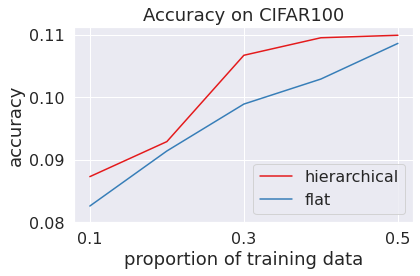

In [138]:
fig, ax = plt.subplots(1,1)

colors = sns.color_palette("Set1", n_colors=2)

types = ['hierarchical', 'flat']

for i, typ in enumerate(types):
    ax.plot(n_props, accuracies[typ], c=colors[i], label=typ)
    
ax.set_title('Accuracy on CIFAR100', fontsize=18)
ax.set_xlabel('proportion of training data', fontsize=18)
ax.set_ylabel('accuracy', fontsize=18)
ax.set_yticks([0.08, 0.09, 0.1, 0.11])
ax.set_xticks([0.1, 0.3, 0.5])

ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

plt.tight_layout()
# plt.savefig('figures/accuracy_cifar100_resource_controlled.pdf')